In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cytoflow as flow
from scipy import stats
#%matplotlib inline

In [2]:
ExperimentIndex = ''
GreenChannel = "EGFP-A"
RedChannel = "mCherry-A"
BlueChannel = 'DAPI-A'

FolderWithFlowFiles  = '/Users/katie/Downloads/mit archive/20.129/VScode_Cytoflow/1_FACsDataTutorial/05032025_full_circuit/'

BlankControlName     = FolderWithFlowFiles+"WT.fcs"
GreenControlName     = FolderWithFlowFiles+"green.fcs"
RedControlName       = FolderWithFlowFiles+"red.fcs"
BlueControlName    = FolderWithFlowFiles+"blue.fcs"

inputs = {
    
    ('DNA0'     ,0   ,'WildType'    ,'WildType-1')      :BlankControlName , 
    ('DNA1'     ,0   ,'Single-Green','Single-Green-1')  :GreenControlName ,
    ('DNA2'     ,0   ,'Single-Red'  ,'Single-Red-1')    :RedControlName ,
    ('DNA3'     ,0   ,'Single-Blue','Single-Blue-1')  :BlueControlName , 
    ('DNA4'     ,0   ,'Positive'    ,'Positive-1')      :FolderWithFlowFiles+'pos.fcs', 
    ('DNA5'     ,0   ,'Negative'    ,'Negative-1')      :FolderWithFlowFiles+'neg.fcs',
    
    ('DNA6'     ,0   ,'Dox-0-level' ,'Dox-0-level-1')   :FolderWithFlowFiles+'0.fcs', 
    ('DNA6'     ,0.001,'Dox-1-level' ,'Dox-1-level-1')   :FolderWithFlowFiles+'0p001.fcs',
    ('DNA6'     ,0.01 ,'Dox-2-level' ,'Dox-2-level-1')   :FolderWithFlowFiles+'0p01.fcs', 
    ('DNA6'     ,0.1   ,'Dox-3-level' ,'Dox-3-level-1')   :FolderWithFlowFiles+'0p1.fcs',
    ('DNA6'     ,1  ,'Dox-4-level' ,'Dox-4-level-1')   :FolderWithFlowFiles+'1.fcs', 
    ('DNA6'     ,10 ,'Dox-5-level' ,'Dox-5-level-1')   :FolderWithFlowFiles+'10.fcs'
}

In [3]:
tubes = []

for (abrevKey, doxKey, typeKey, sampleKey), filename in inputs.items(): #Python 3.0
    tube = flow.Tube(file = filename,
                     conditions = {'Abreviation' : abrevKey,
                                   'DOXLevel' : doxKey,
                                   'GenralType' : typeKey,
                                   'Sample' : sampleKey})
    tubes.append(tube)

import_op = flow.ImportOp(conditions = {'Abreviation' : "category",
                                        'DOXLevel' : "float",
                                        'GenralType' : "category",
                                        'Sample' : "category"},
                          tubes = tubes)
ex = import_op.apply()

In [6]:
ex.data.columns

Index(['Abreviation', 'DAPI-A', 'DOXLevel', 'EGFP-A', 'FSC-A', 'FSC-H',
       'FSC-W', 'GenralType', 'PE-Cy7-A', 'PerCP-Cy5.5-A', 'SSC-A', 'Sample',
       'TIME', 'mCherry-A', 'mPlum-A'],
      dtype='object')

# Morpho Gates

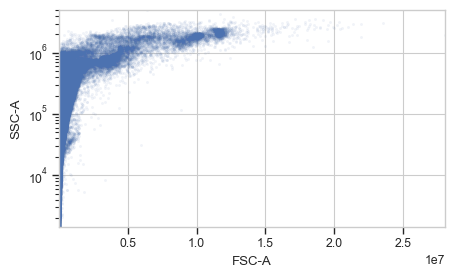

In [4]:
flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A",
                     yscale = "log").plot(ex, alpha = 0.05)

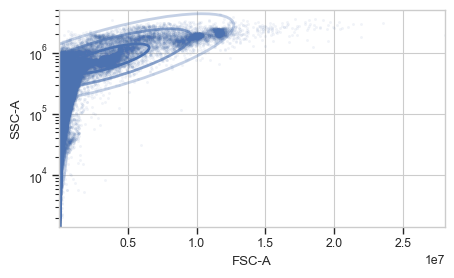

In [5]:
%matplotlib inline
gm_1 = flow.GaussianMixtureOp(name = "Morpho1",
                                channels = ["FSC-A", "SSC-A"],
                                scale = {"SSC-A" : "log"},
                                num_components = 2,
                                sigma = 2)
gm_1.estimate(ex)
gm_1.default_view().plot(ex, alpha = 0.05)
ex_morpho1 = gm_1.apply(ex)

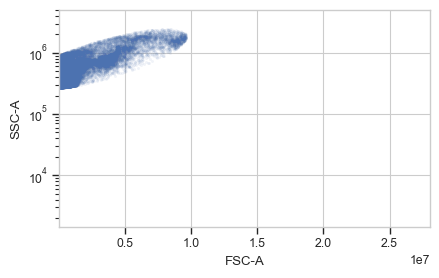

In [6]:
flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A",
                     yscale = "log",
                     subset = "Morpho1_2 == True").plot(ex_morpho1, alpha = 0.05)

(0.0, 2000.0)

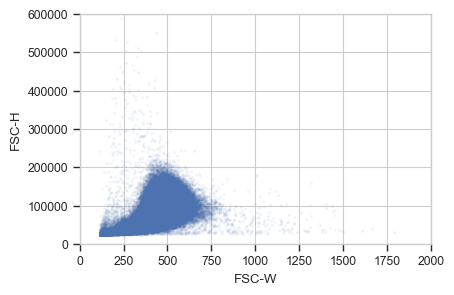

In [7]:
MorphoString = "Morpho1_1 == True"
flow.ScatterplotView(xchannel = "FSC-W",
                     ychannel = "FSC-H",
                     subset = MorphoString).plot(ex_morpho1, alpha = 0.05)
plt.ylim([0,6e5])
plt.xlim([0,2000])

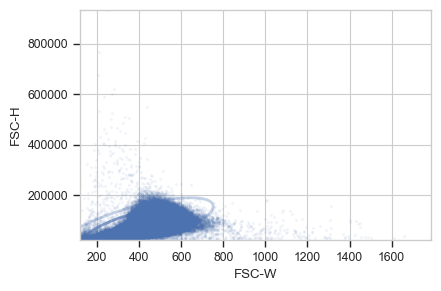

In [8]:
gm_1 = flow.GaussianMixtureOp(name = "Morpho2",
                                channels = ["FSC-W", "FSC-H"],
                                num_components = 1,
                                sigma = 2)
gm_1.estimate(ex_morpho1,subset = MorphoString)
gm_1.default_view(subset = MorphoString).plot(ex_morpho1, alpha = 0.05)

ex_morpho2 = gm_1.apply(ex_morpho1)
#plt.ylim([0,10**4])
#plt.xlim([0,2*10**5])

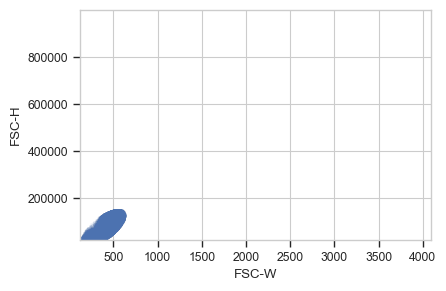

In [9]:
MorphoString = "Morpho1_1 == True and Morpho2_1 == True"
flow.ScatterplotView(xchannel = "FSC-W",
                     ychannel = "FSC-H",
                     subset = MorphoString).plot(ex_morpho2, alpha = 0.05)
#plt.ylim([0,10**4])
#plt.xlim([0,2*10**5])

# AutoFluorescence

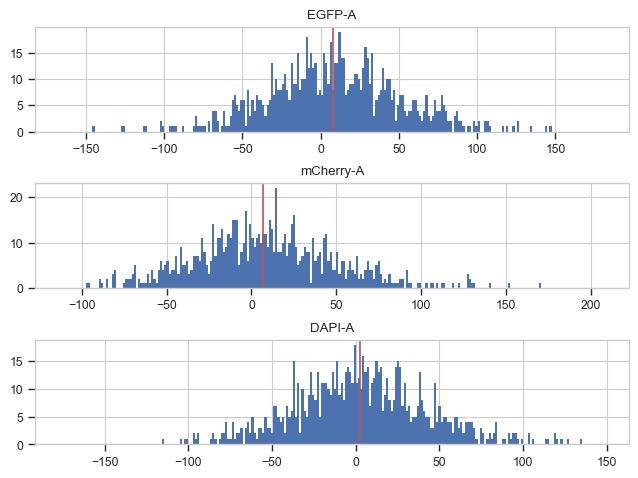

In [10]:
af_op = flow.AutofluorescenceOp()
af_op.blank_file = BlankControlName
af_op.channels = [GreenChannel,RedChannel,BlueChannel]
af_op.estimate(ex_morpho2, subset = MorphoString)
af_op.default_view().plot(ex_morpho2)
plt.rcParams["figure.figsize"] = [10,10]
ex_af = af_op.apply(ex_morpho2)

# Bleedthrough

CPU times: user 38.1 ms, sys: 86.9 ms, total: 125 ms
Wall time: 24.6 ms


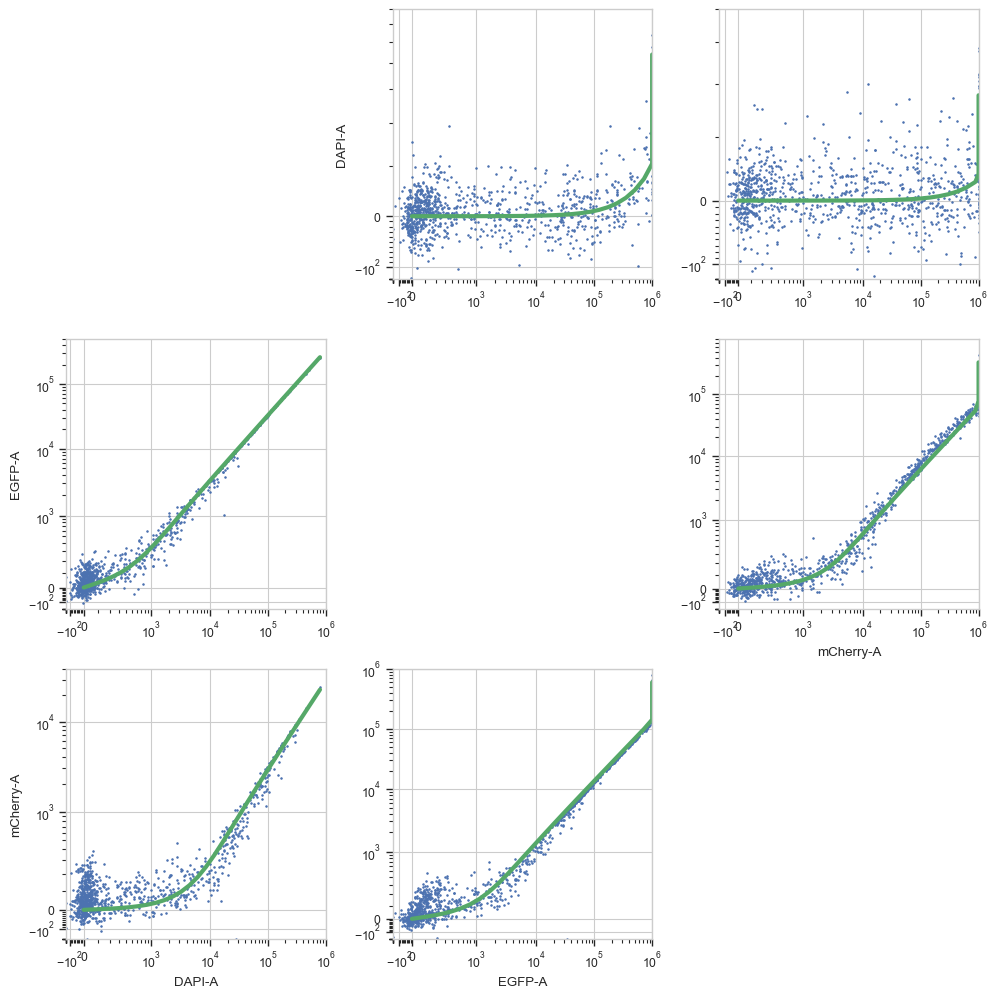

In [11]:
bl_op = flow.BleedthroughLinearOp()
bl_op.controls = {GreenChannel   : GreenControlName,
                  RedChannel     : RedControlName,
                  BlueChannel  : BlueControlName}
bl_op.estimate(ex_af, subset = MorphoString)
bl_op.default_view().plot(ex_af,NROWS=3,NCOLS=3)


%time ex_bl = bl_op.apply(ex_af)

# Bin Data

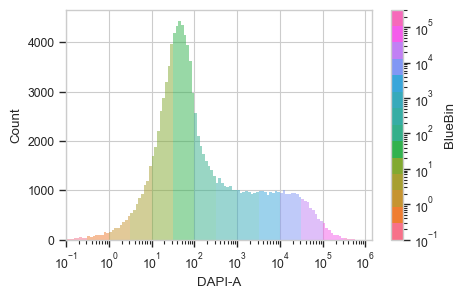

In [12]:
ex_bin = flow.BinningOp(name = "BlueBin",
                        bin_count_name = "BlueBin_Count",
                        channel = BlueChannel,
                        scale = "log",
                        bin_width = 0.5).apply(ex_bl)

flow.HistogramView(channel = BlueChannel,
                   huefacet = "BlueBin",
                   huescale = "log",
                   scale = "log",
                   subset = MorphoString).plot(ex_bin)

# Prliminary Processing

Text(0.5, 1.0, '')

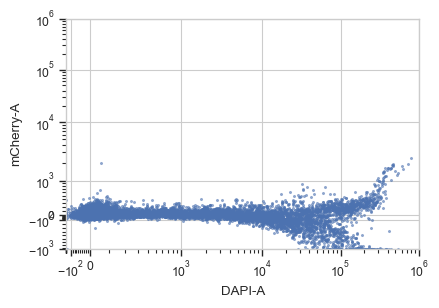

In [13]:
Data2LookAt = MorphoString+" and 'DNA3' in Abreviation"
flow.ScatterplotView(ychannel =  RedChannel,
                     xchannel = BlueChannel,
                     xscale = "logicle",
                     yscale = "logicle",
                     subset = Data2LookAt).plot(ex_bin, alpha = 0.5)
#plt.xlim([0,10**4])
#plt.ylim([0,10**2])
plt.title('')

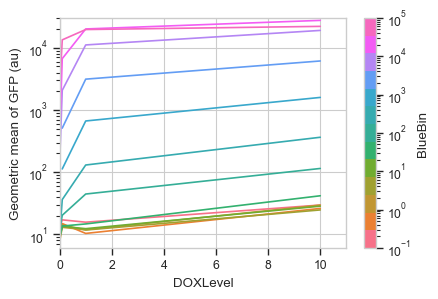

In [56]:
Data2LookAt = MorphoString +" and 'DNA6' in Abreviation and BlueBin_Count > 1000"
# IFP = Input Fluorescent Protien
ex_stat = flow.ChannelStatisticOp(name = 'Green',
                                  by = ['BlueBin','DOXLevel'],
                                  channel = 'EGFP-A',
                                  function = flow.geom_mean,
                                  subset = Data2LookAt).apply(ex_bin)

flow.Stats1DView(statistic = ('Green', 'geom_mean'),
                 variable = 'DOXLevel',
                 scale = 'log',
                #  variable_scale='log',
                 huefacet = 'BlueBin',
                 huescale = 'log',
                 ).plot(ex_stat,ylabel = 'Geometric mean of GFP (au)')

/var/folders/_p/dzd3hk4n1h1dyvmvjbpw99lr0000gn/T/ipykernel_53144/1511154582.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


(0.001, 1000)

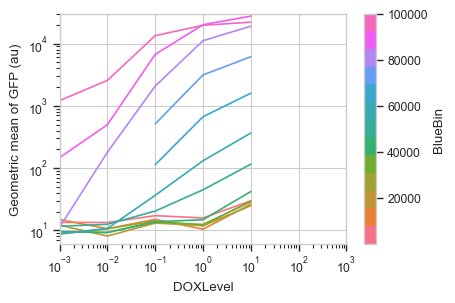

In [17]:
flow.Stats1DView(statistic = ('Green', 'geom_mean'),
                 variable = 'DOXLevel',
                 scale = 'log',
                 huefacet = 'BlueBin',
                #  huescale = 'log',
                 ).plot(ex_stat,ylabel = 'Geometric mean of GFP (au)')
plt.xscale('log')
plt.xlim([0,10**3])

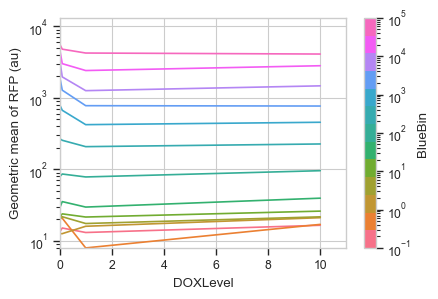

In [57]:
# OFP = Output Florecent Protien
ex_stat2 = flow.ChannelStatisticOp(name = 'Red',
                                  by = ['BlueBin','DOXLevel'],
                                  channel = RedChannel,
                                  function = flow.geom_mean,
                                  subset = Data2LookAt).apply(ex_stat)

flow.Stats1DView(statistic = ('Red', 'geom_mean'),
                 variable = 'DOXLevel',
                 scale = 'log',
                 huefacet = 'BlueBin',
                 huescale = 'log',
                 ).plot(ex_stat2,ylabel = 'Geometric mean of RFP (au)')

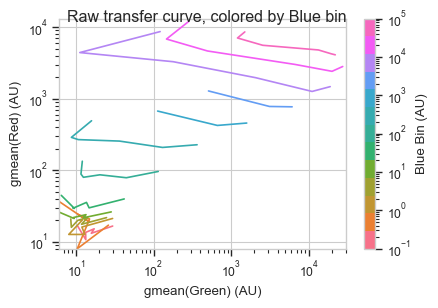

In [21]:
flow.Stats2DView(xstatistic = ("Green", "geom_mean"),
                 ystatistic = ("Red", "geom_mean"),
                 variable = "DOXLevel",
                 xscale = "log",
                 yscale = "log",
                 huescale = "log",
                 huefacet = "BlueBin").plot(ex_stat2,
                                            xlabel = "gmean(Green) (AU)",
                                            ylabel = "gmean(Red) (AU)",
                                            huelabel = "Blue Bin (AU)",
                                            title = "Raw transfer curve, colored by Blue bin")

# Write out to CSV File

In [22]:
for abrev in np.unique(ex_stat2.data['Abreviation']):
    FileName = FolderWithFlowFiles+abrev+'_AU.csv'
    DatatoLookAt = MorphoString+" and ('"+abrev+"' in Abreviation)"
    DataForCSV = ex_stat2.data.query(DatatoLookAt)
    DataForCSV.to_csv(FileName)
